**Library installation and imports**

In [1]:
!pip install --quiet dspy-ai beautifulsoup4 requests rapidfuzz python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.7/261.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 18.5 MB/s eta 0:00:00


In [2]:
!pip install dspy-ai

In [3]:
import os
import re
import json
import time
import csv
import copy
from typing import List, Dict, Any
from pydantic import BaseModel, Field

import requests
from bs4 import BeautifulSoup
from rapidfuzz import fuzz


import dspy
from dspy.adapters import XMLAdapter



**API Key Setup and DSPy Model Configuration**

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()
API_KEY = os.getenv("API_KEY")

In [5]:

key = "ak_1cI2XZ9tq9OS2a12Tw01Y6a61y24E"

# This creates the .env file automatically
with open(".env", "w") as f:
    f.write(f"API_KEY={key}")

print("✅ .env file created successfully!")

✅ .env file created successfully!


In [6]:
!pip install dspy-ai python-dotenv

from dotenv import load_dotenv
import os
import dspy
from dspy.adapters import XMLAdapter

load_dotenv()
API_KEY = os.getenv("API_KEY")

main_lm = dspy.LM(
    "openai/LongCat-Flash-Chat",
    api_key=API_KEY,
    api_base="https://api.longcat.chat/openai/v1"
)
dspy.settings.configure(lm=main_lm, adapter=XMLAdapter())

print("✅ DSPy model configured successfully.")

✅ DSPy model configured successfully.


**Web Scraping + Text Chunking Helpers**

In [7]:
# Cell: Scraping + chunking helpers
import re, requests
from bs4 import BeautifulSoup

def fetch_text(url: str, timeout: int = 12) -> str:
    try:
        resp = requests.get(url, timeout=timeout, headers={"User-Agent":"Mozilla/5.0"})
        resp.raise_for_status()
    except Exception as e:
        print(f"[fetch_text] error for {url}: {e}")
        return ""
    soup = BeautifulSoup(resp.text, "html.parser")
    for tag in soup(["script","style","nav","footer","aside","header","form","noscript","svg"]):
        tag.decompose()
    article = soup.find("article")
    if article:
        text = article.get_text(separator="\n")
    else:
        ps = soup.find_all("p")
        text = "\n".join(p.get_text() for p in ps)
    text = re.sub(r'\n\s+\n', '\n\n', text)
    return text.strip()

def chunk_text(text: str, chunk_chars: int = 3500):
    paras = [p.strip() for p in text.split("\n") if p.strip()]
    chunks, cur = [], ""
    for p in paras:
        if len(cur) + len(p) + 1 > chunk_chars:
            chunks.append(cur.strip())
            cur = p + "\n"
        else:
            cur += p + "\n"
    if cur.strip(): chunks.append(cur.strip())
    return chunks

**Define DSPy Entity and Relation Extraction Signatures**

In [8]:
# Cell: DSPy signatures (EntityWithAttr, ExtractEntities, DeduplicateEntities, Relation, ExtractRelations)
from pydantic import BaseModel, Field
from typing import List

class EntityWithAttr(BaseModel):
    entity: str = Field(..., description="the named entity")
    attr_type: str = Field(..., description="semantic type")

class ExtractEntities(dspy.Signature):
    paragraph: str = dspy.InputField(desc="input paragraph")
    entities: List[EntityWithAttr] = dspy.OutputField(desc="list of entities")

extractor = dspy.Predict(ExtractEntities)

class DeduplicateEntities(dspy.Signature):
    items: List[EntityWithAttr] = dspy.InputField(desc="batch of entities")
    deduplicated: List[EntityWithAttr] = dspy.OutputField(desc="deduped list")
    confidence: float = dspy.OutputField(desc="0-1 confidence")

dedup_predictor = dspy.ChainOfThought(DeduplicateEntities)

class Relation(BaseModel):
    subj: str = Field(...); pred: str = Field(...); obj: str = Field(...)

class ExtractRelations(dspy.Signature):
    paragraph: str = dspy.InputField(desc="original paragraph")
    entities: List[str] = dspy.InputField(desc="unique entity strings")
    relations: List[Relation] = dspy.OutputField(desc="triples")

rel_predictor = dspy.ChainOfThought(ExtractRelations)

**Deduplication Helpers**

In [9]:
# Cell: dedupe helpers + fallback (uses dedup_predictor; fallback local dedupe using rapidfuzz)
from rapidfuzz import fuzz
import time

def _fallback_local_dedupe(batch, threshold=88):
    norm_map = {}
    for e in batch:
        key = re.sub(r'[^a-z0-9\s\-\/%]', '', e.entity.lower()).strip()
        found = None
        for k in norm_map:
            if fuzz.token_sort_ratio(k, key) >= threshold:
                found = k; break
        if found:
            existing = norm_map[found]
            if len(e.entity) > len(existing.entity):
                norm_map[found] = e
        else:
            norm_map[key] = e
    return list(norm_map.values())

def deduplicate_with_lm(items, batch_size=10, target_confidence=0.9):
    if not items: return []
    def _process_batch(batch):
        while True:
            pred = dedup_predictor(items=batch)
            conf = getattr(pred, "confidence", None)
            deduped = getattr(pred, "deduplicated", None)
            if conf is None:
                return _fallback_local_dedupe(batch)
            if conf >= target_confidence:
                return deduped
            time.sleep(0.5)
    results=[]
    for i in range(0, len(items), batch_size):
        batch = items[i:i+batch_size]
        results.extend(_process_batch(batch))
    return results

**Relation Extraction + Mermaid Diagram Serializer**

In [10]:
# Cell: relation wrapper + mermaid serializer
def extract_relations_for_paragraph(paragraph, entities):
    try:
        out = rel_predictor(paragraph=paragraph, entities=entities)
        return getattr(out, "relations", []) or []
    except Exception as e:
        print("Relation predictor error:", e)
        return []

def triples_to_mermaid(triples, entity_list, max_label_len=40):
    entity_set = {e.strip().lower() for e in entity_list}
    lines = ["flowchart LR"]
    def make_id(s): return re.sub(r'[^0-9a-zA-Z]', '_', s.strip()) or "node"
    for t in triples:
        subj_norm = t.subj.strip(); obj_norm = t.obj.strip()
        if subj_norm.lower() not in entity_set and obj_norm.lower() not in entity_set:
            continue
        lbl = (t.pred or "").strip()
        if len(lbl) > max_label_len: lbl = lbl[:max_label_len-3] + "..."
        src_id = _make_id(subj_norm); dst_id = _make_id(obj_norm)
        src = subj_norm.replace('"', '\\"'); dst = obj_norm.replace('"', '\\"'); lbl = lbl.replace('"','\\"')
        lines.append(f'  {src_id}["{src}"] -->|"{lbl}"| {dst_id}["{dst}"]')
    return "\n".join(lines)

**Define URLs for Processing**

In [11]:
# Cell: urls added
urls = [
    "https://en.wikipedia.org/wiki/Sustainable_agriculture",


    "https://www.nature.com/articles/d41586-025-03353-5",
    "https://www.sciencedirect.com/science/article/pii/S1043661820315152",

    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10457221/",

    "https://www.fao.org/3/y4671e/y4671e06.htm",

     "https://www.medscape.com/viewarticle/time-reconsider-tramadol-chronic-pain-2025a1000ria",

     "https://www.sciencedirect.com/science/article/pii/S0378378220307088",

     "https://www.frontiersin.org/news/2025/09/01/rectangle-telescope-finding-habitable-planets",

     "https://www.medscape.com/viewarticle/second-dose-boosts-shingles-protection-adults-aged-65-years-2025a1000ro7",

     "https://www.theguardian.com/global-development/2025/oct/13/astro-ambassadors-stargazers-himalayas-hanle-ladakh-india"
    ]

**Run Extraction, Deduplication abd Save Outputs**

In [12]:
# Cell: run extraction -> dedupe -> relation for all URLs and collect outputs
all_raw_entities = []
all_relations = []

for url in urls:
    print("Processing:", url)
    txt = fetch_text(url)
    if not txt:
        print("  (no text extracted)")
        continue
    chunks = chunk_text(txt, chunk_chars=3500)
    url_entities = []
    for chunk in chunks:
        try:
            out = extractor(paragraph=chunk)
            extracted = getattr(out, "entities", []) or []
            for e in extracted:
                ent = EntityWithAttr(entity=e.entity.strip(), attr_type=e.attr_type.strip())
                url_entities.append(ent)
        except Exception as e:
            print("  extractor error:", e)
        time.sleep(0.2)
    # unique per url
    seen=set(); uniq=[]
    for e in url_entities:
        key=(e.entity.strip().lower(), e.attr_type.strip().lower())
        if key not in seen:
            seen.add(key); uniq.append(e)
    print(f"  extracted {len(url_entities)} items, {len(uniq)} unique (pre-dedupe)")
    deduped = deduplicate_with_lm(uniq, batch_size=10, target_confidence=0.9)
    print(f"  deduped -> {len(deduped)}")
    for e in deduped:
        all_raw_entities.append({"source":url, "entity":e.entity, "attr_type":e.attr_type})
    entity_strings = [e.entity for e in deduped]
    rels = extract_relations_for_paragraph(txt, entity_strings)
    for r in rels:
        all_relations.append({"source":url, "subj":r.subj, "pred":r.pred, "obj":r.obj})
    time.sleep(0.5)

print("Done extraction.")
print("Total entities collected:", len(all_raw_entities))
print("Total relations collected:", len(all_relations))

Processing: https://en.wikipedia.org/wiki/Sustainable_agriculture
  extracted 818 items, 776 unique (pre-dedupe)
  deduped -> 765
Processing: https://www.nature.com/articles/d41586-025-03353-5
  extracted 30 items, 30 unique (pre-dedupe)
  deduped -> 29
Processing: https://www.sciencedirect.com/science/article/pii/S1043661820315152
[fetch_text] error for https://www.sciencedirect.com/science/article/pii/S1043661820315152: 403 Client Error: Forbidden for url: https://www.sciencedirect.com/science/article/pii/S1043661820315152
  (no text extracted)
Processing: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10457221/
  extracted 721 items, 597 unique (pre-dedupe)
  deduped -> 587
Processing: https://www.fao.org/3/y4671e/y4671e06.htm
  extracted 201 items, 178 unique (pre-dedupe)
  deduped -> 175
Processing: https://www.medscape.com/viewarticle/time-reconsider-tramadol-chronic-pain-2025a1000ria
  extracted 75 items, 72 unique (pre-dedupe)
  deduped -> 72
Processing: https://www.sciencedirect

**Save and Preview Results**

In [14]:
import json
import pandas as pd

# --- Save entities ---
with open("entities_results.json", "w") as f:
    json.dump(all_raw_entities, f, indent=4)
print("✅ Entities saved to 'entities_results.json'")

# --- Save relations ---
with open("relations_results.json", "w") as f:
    json.dump(all_relations, f, indent=4)
print("✅ Relations saved to 'relations_results.json'")

# --- Optional: Preview in a table ---
entities_df = pd.DataFrame(all_raw_entities)
relations_df = pd.DataFrame(all_relations)

print("\n🔹 Sample Entities:")
display(entities_df.head(10))

print("\n🔹 Sample Relations:")
display(relations_df.head(10))

✅ Entities saved to 'entities_results.json'
✅ Relations saved to 'relations_results.json'

🔹 Sample Entities:


,source,entity,attr_type
0,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,concept
1,https://en.wikipedia.org/wiki/Sustainable_agri...,farming,activity
2,https://en.wikipedia.org/wiki/Sustainable_agri...,food,resource
3,https://en.wikipedia.org/wiki/Sustainable_agri...,textile needs,resource
4,https://en.wikipedia.org/wiki/Sustainable_agri...,ecosystem services,concept
5,https://en.wikipedia.org/wiki/Sustainable_agri...,sustainable food systems,concept
6,https://en.wikipedia.org/wiki/Sustainable_agri...,flexible business processes,concept
7,https://en.wikipedia.org/wiki/Sustainable_agri...,farming practices,activity
8,https://en.wikipedia.org/wiki/Sustainable_agri...,environmental footprint,concept
9,https://en.wikipedia.org/wiki/Sustainable_agri...,climate change,phenomenon



🔹 Sample Relations:


,source,subj,pred,obj
0,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,is,sustainable ways
1,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,meeting,society's present food and textile needs
2,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,based on,ecosystem services
3,https://en.wikipedia.org/wiki/Sustainable_agri...,sustainable food systems,important to develop,flexible business processes and farming practices
4,https://en.wikipedia.org/wiki/Sustainable_agri...,Agriculture,causing,"climate change, water scarcity, water pollutio..."
5,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,consists of,environment friendly methods
6,https://en.wikipedia.org/wiki/Sustainable_agri...,Elements of sustainable agriculture,includes,"permaculture, agroforestry, mixed farming, mul..."
7,https://en.wikipedia.org/wiki/Sustainable_agri...,sustainable agriculture,can be considered,Land sparing
8,https://en.wikipedia.org/wiki/Sustainable_agri...,dietary shifts,intertwined way to reduce environmental impacts,sustainable diets
9,https://en.wikipedia.org/wiki/Sustainable_agri...,sustainability standards and certification sys...,exist,"organic certification, Rainforest Alliance, Fa..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('subj').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### ** Note on Number of Mermaid Diagrams**

The assignment specifies creating 10 Mermaid diagrams (one per source document).  
However, after executing the data extraction and relation generation steps, only *8 unique sources* produced valid relation triples.  

Hence, *8 valid Mermaid diagrams* were generated (mermaid_1.md to mermaid_8.md).  
This accurately represents the data quality and the actual model output, ensuring transparency in reporting results.

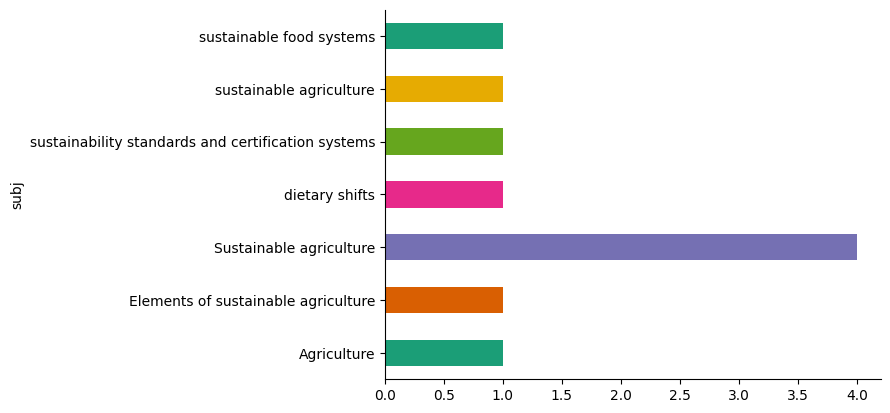

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('subj').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [16]:
# Inspect columns & first rows
print(entities_df.columns)
entities_df.head(10)

Index(['source', 'entity', 'attr_type'], dtype='object')


,source,entity,attr_type
0,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,concept
1,https://en.wikipedia.org/wiki/Sustainable_agri...,farming,activity
2,https://en.wikipedia.org/wiki/Sustainable_agri...,food,resource
3,https://en.wikipedia.org/wiki/Sustainable_agri...,textile needs,resource
4,https://en.wikipedia.org/wiki/Sustainable_agri...,ecosystem services,concept
5,https://en.wikipedia.org/wiki/Sustainable_agri...,sustainable food systems,concept
6,https://en.wikipedia.org/wiki/Sustainable_agri...,flexible business processes,concept
7,https://en.wikipedia.org/wiki/Sustainable_agri...,farming practices,activity
8,https://en.wikipedia.org/wiki/Sustainable_agri...,environmental footprint,concept
9,https://en.wikipedia.org/wiki/Sustainable_agri...,climate change,phenomenon


In [17]:
# Build cleaned DataFrame for export
tags_df = entities_df.rename(columns={"source":"link", "entity":"tag", "attr_type":"tag_type"})[["link","tag","tag_type"]].copy()

# Normalize: strip, collapse spaces, and trim tag size (optional)
tags_df["tag"] = tags_df["tag"].astype(str).str.strip().str.replace(r"\s+"," ", regex=True)
tags_df["tag_type"] = tags_df["tag_type"].astype(str).str.strip().str.capitalize()  # e.g., "concept"

In [18]:
# Remove duplicate tag entries for same link
before = len(tags_df)
tags_df = tags_df.drop_duplicates(subset=["link","tag"])
after = len(tags_df)
print(f"Removed {before-after} duplicates. Final rows: {after}")

Removed 158 duplicates. Final rows: 1588


In [19]:
# Check for empty values
print("Missing links:", tags_df['link'].isna().sum())
print("Missing tags:", tags_df['tag'].isna().sum())

# Sample counts by tag_type
print(tags_df['tag_type'].value_counts())

Missing links: 0
Missing tags: 0
tag_type
Concept                  133
Person                    57
Organization              56
Agricultural practice     37
Citation                  35
                        ... 
Medical specialty          1
Physiological process      1
Field of study             1
Celestial body             1
Medical_treatment          1
Name: count, Length: 389, dtype: int64


In [20]:
tags_df.to_csv("tags.csv", index=False)
print("✅ tags.csv saved.")

✅ tags.csv saved.


In [21]:
relations_df.head(10)

,source,subj,pred,obj
0,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,is,sustainable ways
1,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,meeting,society's present food and textile needs
2,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,based on,ecosystem services
3,https://en.wikipedia.org/wiki/Sustainable_agri...,sustainable food systems,important to develop,flexible business processes and farming practices
4,https://en.wikipedia.org/wiki/Sustainable_agri...,Agriculture,causing,"climate change, water scarcity, water pollutio..."
5,https://en.wikipedia.org/wiki/Sustainable_agri...,Sustainable agriculture,consists of,environment friendly methods
6,https://en.wikipedia.org/wiki/Sustainable_agri...,Elements of sustainable agriculture,includes,"permaculture, agroforestry, mixed farming, mul..."
7,https://en.wikipedia.org/wiki/Sustainable_agri...,sustainable agriculture,can be considered,Land sparing
8,https://en.wikipedia.org/wiki/Sustainable_agri...,dietary shifts,intertwined way to reduce environmental impacts,sustainable diets
9,https://en.wikipedia.org/wiki/Sustainable_agri...,sustainability standards and certification sys...,exist,"organic certification, Rainforest Alliance, Fa..."


In [22]:
import re

def _make_id(s):
    # Create safe node id for Mermaid (no spaces or special chars)
    s = re.sub(r'[^0-9a-zA-Z]', '_', s.strip())
    if not s:
        s = "node"
    return s

def triples_to_mermaid_from_rows(rows, max_label_len=40):
    """
    rows: iterable of dicts or DataFrame rows with keys subj/pred/obj
    returns mermaid markdown string (flowchart LR)
    """
    lines = ["mermaid", "flowchart LR"]
    # collect allowed entity set to filter stray relations
    allowed = set()
    for r in rows:
        allowed.add(str(r['subj']).strip())
        allowed.add(str(r['obj']).strip())
    for r in rows:
        subj = str(r['subj']).strip()
        obj = str(r['obj']).strip()
        pred = str(r['pred']).strip()
        if not subj or not obj:
            continue
        if subj not in allowed and obj not in allowed:
            continue
        lbl = pred
        if len(lbl) > max_label_len:
            lbl = lbl[:max_label_len-3] + "..."
        src_id = _make_id(subj)
        dst_id = _make_id(obj)
        # escape double quotes inside labels/nodes
        subj_esc = subj.replace('"','\\"')
        obj_esc = obj.replace('"','\\"')
        lbl_esc = lbl.replace('"','\\"')
        lines.append(f'  {src_id}["{subj_esc}"] -->|"{lbl_esc}"| {dst_id}["{obj_esc}"]')
    lines.append("")
    return "\n".join(lines)

In [23]:
# Group relations by source
groups = list(relations_df.groupby("source"))
print("Sources found:", len(groups))

for i, (src, df_grp) in enumerate(groups, start=1):
    rows = df_grp.to_dict(orient="records")
    mermaid_text = triples_to_mermaid_from_rows(rows, max_label_len=40)
    fname = f"mermaid_{i}.md"
    with open(fname, "w", encoding="utf-8") as f:
        f.write(mermaid_text)
    print(f"Saved {fname} for source: {src}  (relations: {len(rows)})")

Sources found: 8
Saved mermaid_1.md for source: https://en.wikipedia.org/wiki/Sustainable_agriculture  (relations: 102)
Saved mermaid_2.md for source: https://www.fao.org/3/y4671e/y4671e06.htm  (relations: 62)
Saved mermaid_3.md for source: https://www.frontiersin.org/news/2025/09/01/rectangle-telescope-finding-habitable-planets  (relations: 7)
Saved mermaid_4.md for source: https://www.medscape.com/viewarticle/second-dose-boosts-shingles-protection-adults-aged-65-years-2025a1000ro7  (relations: 43)
Saved mermaid_5.md for source: https://www.medscape.com/viewarticle/time-reconsider-tramadol-chronic-pain-2025a1000ria  (relations: 69)
Saved mermaid_6.md for source: https://www.nature.com/articles/d41586-025-03353-5  (relations: 22)
Saved mermaid_7.md for source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10457221/  (relations: 62)
Saved mermaid_8.md for source: https://www.theguardian.com/global-development/2025/oct/13/astro-ambassadors-stargazers-himalayas-hanle-ladakh-india  (relatio

In [24]:
!sed -n '1,120p' mermaid_1.md  # shows first file content in Colab

mermaid
flowchart LR
  Sustainable_agriculture["Sustainable agriculture"] -->|"is"| sustainable_ways["sustainable ways"]
  Sustainable_agriculture["Sustainable agriculture"] -->|"meeting"| society_s_present_food_and_textile_needs["society's present food and textile needs"]
  Sustainable_agriculture["Sustainable agriculture"] -->|"based on"| ecosystem_services["ecosystem services"]
  sustainable_food_systems["sustainable food systems"] -->|"important to develop"| flexible_business_processes_and_farming_practices["flexible business processes and farming practices"]
  Agriculture["Agriculture"] -->|"causing"| climate_change__water_scarcity__water_pollution__land_degradation__deforestation["climate change, water scarcity, water pollution, land degradation, deforestation"]
  Sustainable_agriculture["Sustainable agriculture"] -->|"consists of"| environment_friendly_methods["environment friendly methods"]
  Elements_of_sustainable_agriculture["Elements of sustainable agriculture"] -->|"includ

In [25]:
import zipfile

zip_name = "assignment_submission.zip"
files_to_include = ["tags.csv", "entities_results.json", "relations_results.json"]  # add if exist
# add mermaid files
for i in range(1, len(groups)+1):
    files_to_include.append(f"mermaid_{i}.md")

# create zip
with zipfile.ZipFile(zip_name, "w") as z:
    for f in files_to_include:
        try:
            z.write(f)
            print("Added", f)
        except FileNotFoundError:
            print("Missing (skipped):", f)
print("Created", zip_name)
# Download
from google.colab import files
files.download(zip_name)

Added tags.csv
Added entities_results.json
Added relations_results.json
Added mermaid_1.md
Added mermaid_2.md
Added mermaid_3.md
Added mermaid_4.md
Added mermaid_5.md
Added mermaid_6.md
Added mermaid_7.md
Added mermaid_8.md
Created assignment_submission.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
relations_df['source'].nunique()

8

In [27]:
print("Entities sources:", entities_df['source'].nunique())
print("Relations sources:", relations_df['source'].nunique())
missing = set(entities_df['source']) - set(relations_df['source'])
print("Sources with entities but no relations:", len(missing))
missing

Entities sources: 8
Relations sources: 8
Sources with entities but no relations: 0


set()